In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision import models

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
manualSeed = 45
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.backends.cudnn.deterministic = True

In [ ]:
!unzip '/content/drive/MyDrive/OfficeHomeDataset_10072016.zip' -d '/content/unzipped_files/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/unzipped_files/OfficeHomeDataset_10072016/Clipart/Spoon/00002.jpg  
  inflating: /content/unzipped_files/OfficeHomeDataset_10072016/Clipart/Spoon/00003.jpg  
  inflating: /content/unzipped_files/OfficeHomeDataset_10072016/Clipart/Spoon/00004.jpg  
  inflating: /content/unzipped_files/OfficeHomeDataset_10072016/Clipart/Spoon/00005.jpg  
  inflating: /content/unzipped_files/OfficeHomeDataset_10072016/Clipart/Spoon/00006.jpg  
  inflating: /content/unzipped_files/OfficeHomeDataset_10072016/Clipart/Spoon/00007.jpg  
  inflating: /content/unzipped_files/OfficeHomeDataset_10072016/Clipart/Spoon/00008.jpg  
  inflating: /content/unzipped_files/OfficeHomeDataset_10072016/Clipart/Spoon/00009.jpg  
  inflating: /content/unzipped_files/OfficeHomeDataset_10072016/Clipart/Spoon/00010.jpg  
  inflating: /content/unzipped_files/OfficeHomeDataset_10072016/Clipart/Spoon/00011.jpg  
  inflating: /content/unzipped_files/OfficeHomeDa

In [ ]:
dataroot_source = "/content/unzipped_files/OfficeHomeDataset_10072016/Clipart"
dataroot_target = "/content/unzipped_files/OfficeHomeDataset_10072016/Real World"

In [ ]:
image_dim = 64

In [ ]:
#transformations for the datasets
source_transform = transforms.Compose([
    transforms.Resize(image_dim),
    transforms.CenterCrop(image_dim),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

target_transform = transforms.Compose([
    transforms.Resize(image_dim),
    transforms.CenterCrop(image_dim),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
batch_size = 128
workers = 2

In [ ]:
#DataLoaders for source and target datasets
source_dataset = datasets.ImageFolder(root=dataroot_source, transform=source_transform)
target_dataset = datasets.ImageFolder(root=dataroot_target, transform=target_transform)

source_loader = DataLoader(source_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
target_loader = DataLoader(target_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

In [ ]:
#the architecture for the Classifier, Feature Extractor, and Discriminator
class FeatureExtractor(nn.Module):
    def __init__(self, in_channels=3):
        super(FeatureExtractor, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model = nn.Sequential(*list(self.model.children())[:-1])

    def forward(self, x):
        features = self.model(x)
        features = features.view(x.size(0), -1)
        return features

class Classifier(nn.Module):
    def __init__(self, num_classes=65):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2048, 1024, bias=True),
            nn.ReLU(),
            nn.Linear(1024, 512, bias=True),
            nn.ReLU(),
            nn.Linear(512, 256, bias=True),
            nn.ReLU(),
            nn.Linear(256, num_classes, bias=True),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, features):
        output = self.model(features)
        return output

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Initialize the models
feature_extractor = FeatureExtractor().to(device)
classifier = Classifier().to(device)
discriminator = Discriminator().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 133MB/s]


In [ ]:
# Number of Epochs
n_epochs = 30
learning_rate = 0.001  # Adjust learning rates as needed
beta1 = 0.5
beta2 = 0.9

In [ ]:
# Define loss functions
loss_class = nn.NLLLoss()
loss_domain = nn.BCEWithLogitsLoss()

In [ ]:
#optimizers
optimizer_classifier = optim.Adam(classifier.parameters(), lr=learning_rate, betas=(beta1, beta2))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, beta2))

In [ ]:
# Function for training the model
def train_model():
    source_loss = []
    source_accuracy = []
    target_loss = []
    target_accuracy = []

    for epoch in range(n_epochs):
        classifier.train()
        discriminator.train()
        total_classifier_loss = 0
        total_discriminator_loss = 0
        total_correct_source = 0
        total_correct_target = 0

        for i, (source_data, target_data) in enumerate(zip(source_loader, target_loader)):
            source_images, source_labels = source_data
            target_images, _ = target_data

            source_images = source_images.to(device)
            source_labels = source_labels.to(device)
            target_images = target_images.to(device)

            optimizer_classifier.zero_grad()
            optimizer_discriminator.zero_grad()

            # Feature extraction
            source_features = feature_extractor(source_images)
            target_features = feature_extractor(target_images)

            # Domain labels (0 for source, 1 for target)
            source_domain_labels = torch.zeros(source_images.size(0), 1).to(device)
            target_domain_labels = torch.ones(target_images.size(0), 1).to(device)

            # Classifier output
            class_output = classifier(source_features)

            # Discriminator outputs
            source_domain_output = discriminator(source_features)
            target_domain_output = discriminator(target_features)

            # Loss calculation
            class_loss = loss_class(class_output, source_labels)
            domain_loss = loss_domain(source_domain_output, source_domain_labels) + loss_domain(target_domain_output, target_domain_labels)

            total_loss = class_loss + domain_loss

            total_loss.backward()
            optimizer_classifier.step()
            optimizer_discriminator.step()

            total_classifier_loss += class_loss.item()
            total_discriminator_loss += domain_loss.item()

            total_correct_source += (class_output.max(1)[1] == source_labels).sum().item()
            total_correct_target += (class_output.max(1)[1] == source_labels).sum().item()

        source_loss.append(total_classifier_loss)
        source_accuracy.append(total_correct_source / len(source_dataset) * 100)
        target_loss.append(total_discriminator_loss)
        target_accuracy.append(total_correct_target / len(target_dataset) * 100)

        print("[Epoch %d/%d] [Classifier Loss: %f] [Discriminator Loss: %f] [Source Accuracy: %f] [Target Accuracy: %f]" %
              (epoch, n_epochs, total_classifier_loss, total_discriminator_loss,
               total_correct_source / len(source_dataset) * 100, total_correct_target / len(target_dataset) * 100))

        print('Time elapsed: %.2f min' % ((time.time() - start_time) / 60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time) / 60))

    return source_loss, source_accuracy, target_loss, target_accuracy


In [ ]:
#the model trainning
start_time = time.time()
source_loss, source_accuracy, target_loss, target_accuracy = train_model()


[Epoch 0/30] [Classifier Loss: 142.599689] [Discriminator Loss: 48.631774] [Source Accuracy: 3.619702] [Target Accuracy: 3.626348]
Time elapsed: 1.80 min
[Epoch 1/30] [Classifier Loss: 131.493038] [Discriminator Loss: 48.591215] [Source Accuracy: 9.713631] [Target Accuracy: 9.731467]
Time elapsed: 3.46 min
[Epoch 2/30] [Classifier Loss: 121.082137] [Discriminator Loss: 44.480810] [Source Accuracy: 14.272623] [Target Accuracy: 14.298829]
Time elapsed: 5.28 min
[Epoch 3/30] [Classifier Loss: 113.035939] [Discriminator Loss: 42.718978] [Source Accuracy: 19.954181] [Target Accuracy: 19.990819]
Time elapsed: 6.92 min
[Epoch 4/30] [Classifier Loss: 104.847102] [Discriminator Loss: 39.789822] [Source Accuracy: 24.352806] [Target Accuracy: 24.397521]
Time elapsed: 8.72 min
[Epoch 5/30] [Classifier Loss: 96.089833] [Discriminator Loss: 38.413299] [Source Accuracy: 30.698740] [Target Accuracy: 30.755107]
Time elapsed: 10.38 min
[Epoch 6/30] [Classifier Loss: 87.000295] [Discriminator Loss: 34.89

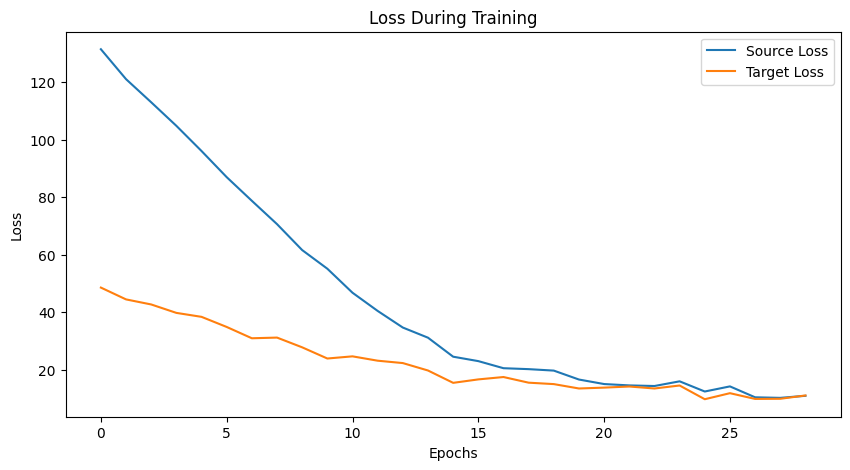

In [ ]:
#the results (loss and accuracy) plot
plt.figure(figsize=(10, 5))
plt.title("Loss During Training")
plt.plot(source_loss[1:], label="Source Loss")
plt.plot(target_loss[1:], label="Target Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


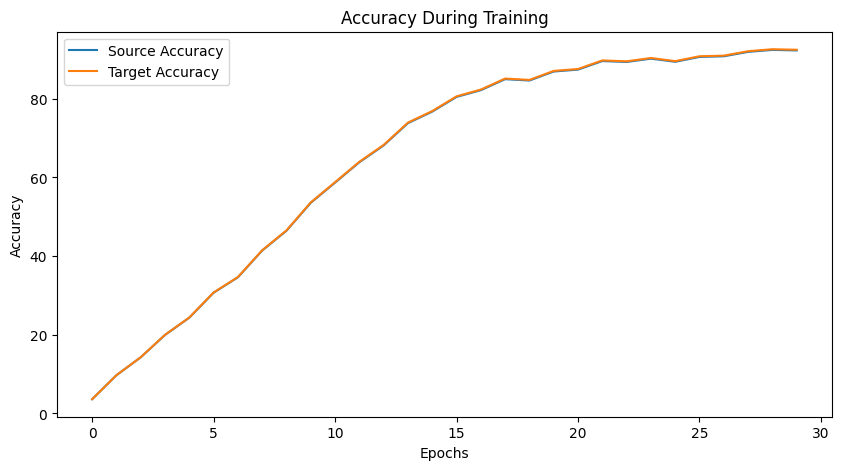

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Accuracy During Training")
plt.plot(source_accuracy, label="Source Accuracy")
plt.plot(target_accuracy, label="Target Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()